<div style="padding: 20px;
  text-align: center;
  background: #cee9ce;
  color: #003049;
  font-size: 14px;">
  <h2><b>Math Behind Trend in Prophet</b></h2>
   <hr>
</div>

# Introduction

**`prophet`**
 - Dikembangkan oleh facebook untuk membuat pemodelan data time series lebih mudah diakses oleh non ekspert.
 - Pendekatan yang sederhana sehingga mudah dipahami dan cocok untuk pemula
 - `prophet` memanfaatkan GAM yang menambahkan efek hari libur untuk memodelkan jadwal yang tidak teratur.


**General Additive Model (GAM)**
Salah satu kemajuan terbaru dalam pemodelan data time series yang memandang time series sebagai hasil penjumlahan dari komponennya: 
> $Y(t) = T(t) + S(t) + E(t)$
- **Trend (T)**: Pergerakan jangka panjang dalam nilai rata-ratanya.
- **Seasonality (S)**: Efek musiman berulang.
- **Residuals (E)**: Komponen tak teratur atau fluktuasi acak yang tidak dijelaskan oleh tren dan musiman.

# Goal

**Tujuan utama artikel ini adalah untuk:** Memahami model trend yang digunakan Prophet: Menjelaskan secara mendalam persamaan matematis dan konsep di balik model trend Prophet, seperti trend linear, logistik, dan musiman.

In [1]:
import pandas as pd
daily_sales_31 = pd.read_csv("data/daily_sales_31.csv", parse_dates=['date'])
daily_sales_31

,date,shop_id,total_qty,total_revenue
0,2013-01-02,31,568.0,396376.10
1,2013-01-03,31,423.0,276933.11
2,2013-01-04,31,431.0,286408.00
3,2013-01-05,31,415.0,273245.00
4,2013-01-06,31,435.0,260775.00
...,...,...,...,...
1026,2015-10-27,31,123.0,111851.00
1027,2015-10-28,31,117.0,180557.00
1028,2015-10-29,31,152.0,103456.00
1029,2015-10-30,31,267.0,204317.00


# Trend Component

🔎 **Definisi**
> Menggambarkan pergerakan jangka panjang dalam data

🔎 **Arah Tren**
> Dapat bergerak ke atas (tren naik) atau ke bawah (tren turun)
>> - Tren naik mengindikasikan peningkatan nilai dari waktu ke waktu, 
>> - Tren turun menunjukkan penurunan nilai.

🔎 **Tren vs. Fluktuasi**
> Tren harus dibedakan dari fluktuasi. Tren adalah perubahan jangka panjang, sedangkan fluktuasi adalah perubahan jangka pendek.

🔻 **Visualisasi Prophet dalam Menghasilkan Tren**

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20220\90503174.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


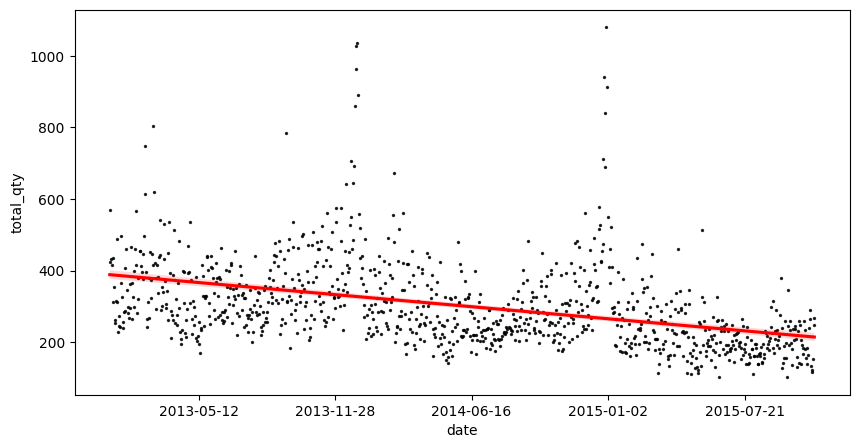

In [2]:
# for illustration purposes only
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns

## prepare data
daily_sales_31_copy = daily_sales_31.copy()
daily_sales_31_copy['date_ordinal'] = daily_sales_31_copy['date'].apply(lambda date: date.toordinal())

## visualize regression line
plt.figure(figsize=(10, 5))
ax = sns.regplot(x='date_ordinal', y='total_qty', data=daily_sales_31_copy,
            scatter_kws={'color': 'black', 's': 2},
            line_kws={'color': 'red'})
new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
plt.xlabel('date')
plt.show()

📈 **Visualisasi Linier:** Grafik tren yang dihasilkan oleh Prophet secara default adalah garis lurus (linear) ketika ditampilkan dalam visualisasi. Ini mencerminkan model tren linier yang digunakan dalam perhitungan.

🔎 **Default Linear Tren**
> Prophet secara default mengasumsikan bahwa tren dalam data time series adalah **tren linear**. Ini berarti Prophet memodelkan perubahan nilai data sebagai **peningkatan atau penurunan ($T(t)$) yang terjadi dengan laju yang konstan sepanjang waktu ($t$)** 

# Mathematics Behind Trend

**Rumus Tren Default:** Secara matematis, rumus tren default dalam Prophet adalah:
   
   $T(t) = \beta_0 + \beta_1 \cdot t$
   
   Di mana:
   - $T(t)$ adalah nilai tren pada waktu $t$.
   - $\beta_0$ adalah intercept (potongan garis tren).
   - $\beta_1$ adalah koefisien kemiringan (slope) yang menunjukkan tingkat perubahan tren seiring waktu.

**Tren Naik dan Turun:** 
> Koefisien $\beta_1$ dalam rumus di atas menentukan apakah tren adalah tren naik ($\beta_1 > 0$) atau tren turun ($\beta_1 < 0$). Nilai $\beta_1$ menggambarkan tingkat perubahan tren dalam unit data per unit waktu.



Model linear pada trend akan membuat sebuah garis lurus melintasi sumbu x menggunakan metode ordinary least square (yaitu garisnya akan dibuat sedemikian rupa agar terdapat beda paling sedikit antara garis dengan nilai sesungguhnya dan menghasilkan perata-rataan yang berubah terhadap waktu). Konsepnya adalah membuat sebuah garis regresi linear dengan perumusan:

$$y=mx+C$$

Pada kasus kita, ketika kita ingin membuat model dari komponen trend maka `y` akan menjadi `Trend`, `m` akan menjadi perbedaan setiap perubahan waktu, dan C untuk intercept. Secara perumusan akan menjadi:

$$T(date)=m(date)+C$$

Untuk membuat ilustrasi slope pada trend, kita dapat membuat sebuah model dengan fungsi `ols()` dari library `statsmodels`:

In [3]:
# import the library
import statsmodels.api as sm

# define predictor and target variable
X = daily_sales_31_copy['date_ordinal']
y = daily_sales_31_copy['total_qty']

# build ols model
X_train_sm = sm.add_constant(X)
lr = sm.OLS(y, X_train_sm).fit()

# printing the parameters
lr.params

const           124413.733302
date_ordinal        -0.168772
dtype: float64

Berdasarkan hasil summary, didapatkan persamaan linearnya:

$$demand.in.qty=−0.17date+124413.733$$

📝 **Insight:**

- Koefisien slope (-0.17) menunjukkan bahwa terdapat tren negatif (penurunan) seiring berjalannya waktu. Setiap peningkatan unit waktu akan menyebabkan penurunan sebesar 0.17 unit dalam "demand.in.qty."
- Intercept (124413.733) adalah nilai "demand.in.qty" pada waktu awal (intersep sumbu Y ketika waktu = 0).


<hr>

<div class="alert alert-success">
  <center><b>Penyesuaian Fleksibilitas</b><br><hr>
    Meskipun defaultnya adalah model tren linier, Prophet memungkinkan penyesuaian dan penanganan tren non-linier jika diperlukan dengan mengontrol parameter-parameter seperti <code>changepoints</code> untuk mengidentifikasi perubahan tren.</center>
</div> 